In [3]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
import ctypes
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.26/00


In [4]:
#this is my framework for bayesian fits and pretty plots
class bayesian_fit():
    def __init__(self,data,stanfile,nsamples=1000):
        self.data=data
        self.stan_data={'n':len(self.data['n'].values),
             'phi':list(self.data['phi'].values),
             'asym':list(self.data['asym'].values),
           'dasym':list(self.data['dasym'].values)}
        self.stanfile=stanfile
        self.x=self.data['phi']
        self.y=self.data['asym']
        self.dy=self.data['dasym']
        self.model = sp.CmdStanModel(stan_file=stanfile)
        self.fitobj = self.model.sample(data=self.stan_data,iter_sampling=nsamples)
    #funtion w/o phase
    def f(self,x,a):
            return a*np.cos(2*np.pi/180.*(-45-x))
    #function with phase
    def f1(self,x,a,b,c):
            return a*np.cos(x+c)+b
    #chi2 parameters of fitted data
    def get_chisqpars(self,function):
            popt, pcov = curve_fit(function,self.data['phi'].values,self.data['asym'].values,
                                   sigma=self.data['dasym'].values)
            return popt,pcov
    #print stan code
    def stan_code(self):
        return self.model.code()
    #get pd dataframe of samples
    def samples_df(self):
        return self.fitobj.draws_pd()
    #calculate waic for given samples and log likelihoods
    def waic(self):
        samples=self.fitobj.draws_pd()
        pwaic=np.array([np.var(samples[f'log_lik[{i+1}]'], ddof=1)for i in range(len(self.data['phi']))])
        lpd=np.array([np.log(np.mean(np.exp(samples[f'log_lik[{i+1}]'])))for i in range(len(self.data['phi']))])
        elpd=lpd-pwaic
        se=np.sqrt(len(self.x)*np.var(elpd,ddof=1))
        return sum(elpd), se, elpd
    #single method for pvalue
    def pval(self):
        samples=self.fitobj.draws_pd()
        y_arr=[samples[f'y_tilde[{i+1}]']for i in range(len(self.data['phi']))]
        pvalue=[len([y for y in y_arr[i] if y>=self.data['asym'][i]])/len(y_arr[i])for i in range(len(self.data['phi']))]
        return pvalue
    #plot posterior predictive distributions
    def plot_ppd(self,save,i,display,fitfunc,width=.5):
        samples=self.fitobj.draws_pd()
        #cosmetics
        fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]},num=1,clear=True)
        ax.set_ylabel('$p(A_{rep}|A)$')
        ax.set_xlim([-180,180])
        ax.xaxis.set_ticks_position("top")
        ax.grid(which='minor',color='grey',lw='.4')
        #get results from chisq fit and plot them
        xx=np.linspace(np.min(self.data['phi']),np.max(self.data['phi']),200)
        params=self.get_chisqpars(fitfunc)[0]
        yfit=fitfunc(xx,*params)
        ax.errorbar(x=self.data['phi'],y=self.data['asym'],yerr=self.data['dasym'],fmt='.',label='Data points',color='darkorange')
        #ax.plot(data['x'],data['y'],'x',label='Data points')
        ax.plot(xx,yfit,'r-',label='$\chi^2$ fit',color='darkorange')
        #violinplot for the replicated samples
        vp=ax.violinplot([samples[f'y_tilde[{i+1}]']for i in range(len(self.data['phi']))],np.array(self.x),
                         showmeans=False, showextrema=False, showmedians=False,widths=width)
        #cosmetics
        for b in vp['bodies']:
            # get the center
            m = np.mean(b.get_paths()[0].vertices[:, 0])
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
            b.set_alpha(.5)
            b.set_color('midnightblue')

        #compute p value as measure of goodness of fit
        y_arr=[samples[f'y_tilde[{i+1}]']for i in range(len(self.data['phi']))]
        pvalue=[len([y for y in y_arr[i] if y>=self.data['asym'][i]])/len(y_arr[i])
                for i in range(len(self.data['phi']))]
        pvalue_lower=[len([y for y in y_arr[i] if y-self.data['dasym'][i]>=self.data['asym'][i]])/len(y_arr[i])
                for i in range(len(self.data['phi']))]
        pvalue_upper=[len([y for y in y_arr[i] if y+self.data['dasym'][i]>=self.data['asym'][i]])/len(y_arr[i])
                for i in range(len(self.data['phi']))]
        pval_errors=[np.abs(np.array(pvalue_lower)-np.array(pvalue)),np.abs(np.array(pvalue_upper)-np.array(pvalue))]
        #plot pvalue
        #ax1.grid(which='minor',color='grey',lw='.4')
        ax1.errorbar(x=self.data['phi'],y=pvalue,yerr=pval_errors,fmt='.',color='midnightblue')
        ax1.axhline(y=0.5, color='darkorange', linestyle='--',label='optimal value')
        ax1.set_xlabel('$\phi$ / deg')
        ax1.set_ylabel('$T(A_{rep}>A)$')
        ax1.set_ylim([-0.1,1.1])
        #cosmetics and legend
        plt.subplots_adjust(wspace=0, hspace=0)
        lines,labels = ax.get_legend_handles_labels() 
        patch = mpatches.Patch(color='midnightblue', label='$A_{rep}$',alpha=.5)
        lines.append(patch)
        lines1,labels1=ax1.get_legend_handles_labels()
        lines+=lines1
        tmp=lines[0]
        lines[0]=lines[1]
        lines[1]=tmp
        plt.legend(handles=lines,bbox_to_anchor=(1,2))
        fig.suptitle(f'toybin{i:04d}',y=1.1)
        if (save==True):
            plt.savefig(f'./ppd_checks/toybin{i:04d}.pdf',format='pdf',bbox_inches='tight',dpi=1000)
        if (display==True):
            plt.show()
    # plot posterior distributions of desired parameters, indicate chi2 fit value(s) and error(s)
    def plot_posterior(self,params,func,save=False):
        samples=self.fitobj.draws_pd()
        chi2pars=self.get_chisqpars(function=func)
        fig, (ax)=plt.subplots(ncols=1,nrows=len(params),dpi=1000)
        #print(len(params))
        
        #plot data
        ax.grid(False)
        ax.errorbar(x=chi2pars[0][i],y=0,xerr=np.sqrt(chi2pars[1][i,i]),label='$\chi^2$-fit',color='blue')
        #plot posterior kde distribution bc pretty
        sns.distplot(samples[params[i]],hist=True,kde=True,ax=ax,kde_kws={'bw':0.35})
        kde_curve = ax.lines[0]
        x = np.array(kde_curve.get_xdata())
        y = np.array(kde_curve.get_ydata())
        maxpos = y.argmax()
        maxx=x[maxpos]
        counts, bins = np.histogram(samples[params[i]],bins=20)
        mean=np.mean(samples[params[i]])
        sd=np.std(samples[params[i]],ddof=1)
        #mids = 0.5*(bins[1:] + bins[:-1])
        #probs = counts / np.sum(counts)
    
        #mean = np.sum(probs * mids)  
        #sd = np.sqrt(np.sum(probs * (mids - mean)**2))
        #indicate chi2 values
        #ax.axvline(x=maxx,ymin=0,ymax=1,linewidth='.5',label='MPV',color='red')
        ax.axvline(x=mean,ymin=0,ymax=1,linewidth='.5',label='$\mu\pm 1\sigma$',color='red',linestyle='dashed')
        ax.axvline(x=mean-sd,ymin=0,ymax=1,linewidth='.5',color='red',linestyle='dashed')
        ax.axvline(x=mean+sd,ymin=0,ymax=1,linewidth='.5',color='red',linestyle='dashed')
        #cosmetics and legend
        ax.legend(bbox_to_anchor=(1,1.2),fontsize=10)
        #cosmetics
        ax.set_xlabel('$\Sigma$',fontsize=10)
        ax.set_ylabel('Frequency',fontsize=10)
        ax.tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
        ax.tick_params(axis='x', which='both',labelsize=10)
        ax.set_xlim([-1,1])
        #plt.subplots_adjust(hspace=1)
        if(save):
            fig.savefig(f'./posterior_{len(params)}_params.pdf',format='pdf',dpi=1000)

    # function to plot the posterior distributions as is     
    def plot_trace(self,params,save=False):
        samples=self.fitobj.draws_pd()
        fig, (ax)=plt.subplots(ncols=2,nrows=len(params),dpi=1000)
        #print(ax.shape)
        ls=['solid','dotted','dashed','dashdot']
        for i in range(len(params)):
            ax[i][0].grid(visible=False,axis='y')
            ax[i][0].set_xlabel(params[i],fontsize=10)
            ax[i][0].set_ylabel('Frequency',fontsize=10)
            ax[i][1].set_xlabel('iteration',fontsize=10)
            ax[i][1].set_ylabel(params[i],fontsize=10)
            for k in range(4):
                sns.kdeplot(samples[params[i]][k*1000:(k+1)*1000],ax=ax[i][0],linestyle=ls[k],color='black',
                            linewidth=.5,bw=0.35)
                ax[i][1].plot(np.arange(0,len(samples[params[i]])/4),
                              samples[params[i]][k*1000:(k+1)*1000],ls=ls[k],color='black',alpha=.7,linewidth=.5)
                for j in (0,1):
                    ax[i][j].tick_params(axis='y', which='both',left=False,right=False,labelleft=False)
                    #ax[i][j].set_title(params[i])
                    ax[i][j].tick_params(axis='both', which='major', labelsize=10)
        plt.subplots_adjust(hspace=1)
        #fig.set_size_inches(8.29,1*len(params))
def find_y_for_x(x, y, value):
    for i in range(len(x)):
        if x[i]<= value and x[i+1]>= value:
            return y[i]
            break
        
#calculate savage dickey density ratio = Bayes factor
def plot_sddr(samples,fixpar,saveas):#this is the model with one parameter more
    fig, ax =plt.subplots(dpi=1000)
    #define prior data and get posterior using kde
    x=np.linspace(-.5,.5,1000)
    def prior(x):
        return stats.norm.pdf(x,0,np.pi)
    priorval=prior(fixpar)
    sns.distplot(samples,hist=True,kde=True,ax=ax,kde_kws={'bw':0.35},label='$p(c|y,M_1)$')
    kde_curve = ax.lines[0]
    xx = kde_curve.get_xdata()
    y = kde_curve.get_ydata()
    postval=find_y_for_x(xx,y,fixpar)
    #plot
    ax.plot(x,prior(x),label='$\pi(c|M_1)$')
    ax.vlines(fixpar,0,np.max(y),linestyle='--',color='peachpuff',label='BF={:.2f}'.format(postval/priorval))
    ax.legend(bbox_to_anchor=(1,1))
    fig.savefig(saveas,format='pdf',dpi=1000,bbox_inches='tight')
def elpd_diff(fit,fit1):
    elpd=np.array(fit.waic()[2])
    elpd1=np.array(fit1.waic()[2])
    return np.abs(sum(elpd)-sum(elpd1)),np.sqrt(len(fit.x)*np.var(elpd-elpd1))

In [8]:
def fitfunc(x,sigma):
    return sigma*np.cos(2*(-45-x)*np.pi/180.)

def fit(nsamples,nbins,start): #define starting index
    cols=[f'toybin{i:04d}' for i in range(start,start+nbins)]
    index=['sigma_median','mcse','rhat']
    for i in range(12):
        index.append(f'pval{i:02d}')
    
    diagnostics_df=pd.DataFrame(columns=cols,index=index)
    sigma_df=pd.DataFrame(columns=cols)
    sigma_chi2_df=pd.DataFrame(columns=cols,index=['sigma','error'])

    for i in range(start,start+nbins):#no. of toy bins
        #read data
        df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
        #df=pd.read_csv(f"new_toy_MC.txt",sep="\t")
        df.columns=['pol','setting','phi']
        #now write data to histo
        p45=df.loc[df['setting']==+45]
        m45=df.loc[df['setting']==-45]
        
        hp45=r.TH1F(f"hp45_{i}",";#phi;",12,-180,180)
        hm45=r.TH1F(f"hm45_{i}",";#phi;",12,-180,180)

        for k in p45['phi']:
            hp45.Fill(k)
        for k in m45['phi']:
            hm45.Fill(k)

        #now build event yield asymmetry
        #write histos to arrays
        p45_arr=[]
        m45_arr=[]
        for k in range(12):
            p45_arr.append(hp45.GetBinContent(k+1))
            m45_arr.append(hm45.GetBinContent(k+1))
            
        p45_arr=np.array(p45_arr)
        m45_arr=np.array(m45_arr)
        
        
        
        #first, normalize event yields
        norm_p_err=ctypes.c_double(0.)
        norm_m_err=ctypes.c_double(0.)
        
        norm_p=hp45.IntegralAndError(0,-1,norm_p_err,"")
        norm_m=hm45.IntegralAndError(0,-1,norm_m_err,"")
        
        p45_arr*=1./norm_p
        m45_arr*=1./norm_m
        #c=r.TCanvas()

        

        #enumerator of asymmetry
        enum=p45_arr-m45_arr
        #nominator of asymmetry
        nom=0.25*p45_arr+0.3*m45_arr
        final_e=[]
        for k in range(12):
            n_bot=hp45.GetBinContent(k+1)
            n_bot_err=hp45.GetBinError(k+1)
            #print(n_bot,n_bot_err)
            n_par=hm45.GetBinContent(k+1)
            n_par_err=hm45.GetBinError(k+1)
            pol_bot=0.3
            pol_par=0.25
            tmp_enum=((n_bot*n_par*norm_m*(pol_bot+pol_par)*norm_p_err.value)**2
                    +(n_bot*n_par*norm_p*(pol_bot+pol_par)*norm_m_err.value)**2
                    +(n_par*norm_p*norm_m*(pol_bot+pol_par)*n_bot_err)**2
                    +(n_bot*norm_p*norm_m*(pol_bot+pol_par)*n_par_err)**2)
            tmp_nom=np.power(pol_par*n_bot*norm_m+pol_bot*n_par*norm_p,4)
            final_e.append(np.sqrt(tmp_enum/tmp_nom))
        
        #enum.Divide(nom)
        #set error
        #save the data in a dataframe!
        #create arrays with y,dy
        asym=enum/nom
        phibins=[]
        for k in range(12):
            phibins.append(hp45.GetXaxis().GetBinCenter(k+1))
        
        stan_data={
            'n':len(asym), #no. of bins
            'phi':phibins, # bin centres of phi
            'asym':asym, #value of asymmetry 
            'dasym':final_e,#error of asymmetry
        }
        df_stan=pd.DataFrame(stan_data)
        
        #fit with mcmc and get samples
        fit=bayesian_fit(data=df_stan,stanfile='stan_file.stan',nsamples=nsamples)
        sigma=fit.samples_df()['sigma']
        #write results
        currbin=f"toybin{i:04d}"
        sigma_df[currbin]=sigma
        #write chi2 results
        popt, pcov = curve_fit(fitfunc,df_stan['phi'].values,df_stan['asym'].values,
                                   sigma=df_stan['dasym'].values)
        sigma_chi2_df[currbin]=[popt[0],np.sqrt(pcov[0][0])]
        #get fit diagnostics, i.e. pvalue
        pvalue=fit.pval()
        #get mcmc diagnostics, i.e. r_hat and median+mcse
        summary=fit.fitobj.summary()
        median=(summary['50%']['sigma'])
        mcse=(az.mcse(np.transpose(fit.fitobj.draws(concat_chains=False)[:,:,7]),method='median'))
        #print(fit.fitobj.draws_pd())
        rhat=(summary['R_hat']['sigma'])
        dlist=[median,mcse,rhat]
        dlist.extend(pvalue)
        #write diagnostics
        diagnostics_df[currbin]=dlist
        #make ppd plots
        #fit.plot_ppd(save=True,i=i,display=False,fitfunc=fit.f,width=50)
        print(f'fitted toyMC exp. no. {i}')

    return diagnostics_df, sigma_df, sigma_chi2_df
    #return sigma_chi2_df

In [ ]:
res=fit(nsamples=1000,nbins=3000,start=0)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 3


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 4


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 5


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 6


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 7


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 8


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 9


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 10


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 11


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 12


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 13


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 14


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 15


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 16


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 17


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 18


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 19


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 20


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 21


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 22


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 23


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 24


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 25


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 26


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 27


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 28


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 29


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 30


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 31


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 32


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 33


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 34


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 35


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 36


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 37


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 38


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 39


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 40


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 41


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 42


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 43


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 44


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 45


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 46


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 47


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 48


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 49


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 50


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 51


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 52


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 53


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 54


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 55


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 56


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 57


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 58


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 59


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 60


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 61


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 62


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 63


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 64


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 65


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 66


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 67


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 68


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 69


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 70


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 71


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 72


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 73


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 74


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 76


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 77


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 78


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 79


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 80


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 81


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 82


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 83


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 84


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 85


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 86


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 87


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 88


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 89


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 90


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 91


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 92


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 93


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 94


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 95


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 96


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 97


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 98


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 99


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 100


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 101


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 102


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 103


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 104


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 105


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 106


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 107


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 108


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 109


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 110


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 111


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 112


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 113


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 114


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 115


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 116


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 117


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 118


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 119


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 120


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 121


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 122


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 123


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 124


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 125


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 126


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 127


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 128


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 129


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 130


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 131


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 132


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 133


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 134


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 135


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 136


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 137


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 138


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 139


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 140


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 141


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 142


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 144


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 145


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 146


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 147


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 148


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 149


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 150


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 151


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 152


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 153


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 154


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 155


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 156


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 157


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 158


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 159


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 160


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 161


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 162


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 163


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 164


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 165


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 166


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 167


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 168


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 169


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 170


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 171


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 172


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 173


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 174


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 175


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 176


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 177


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 178


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 179


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 180


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 181


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 182


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 183


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 184


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 185


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 186


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 187


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 188


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 189


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 190


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 191


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 192


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 193


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 194


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 195


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 196


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 197


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 198


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 199


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 200


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 201


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 202


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 203


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 204


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 205


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 206


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 207


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 208


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 209


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 210


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 211


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 212


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 213


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 214


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 215


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 216


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 217


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 218


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 219


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 220


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 221


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 222


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 223


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 224


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 225


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 226


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 227


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 228


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 229


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 230


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 231


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 232


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 233


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 234


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 235


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 236


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 237


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 238


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 239


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 240


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 241


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 242


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 243


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 244


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 245


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 246


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 247


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 248


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 249


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 250


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 251


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 252


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 253


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 254


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 255


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 256


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 257


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 258


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 259


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 260


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 261


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 262


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 263


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 264


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 265


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 266


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 267


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 268


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 269


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 270


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 271


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 273


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 274


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 275


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 276


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 277


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 278


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 279


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 280


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 281


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 282


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 283


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 284


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 285


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 287


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 288


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 289


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 290


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 291


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 292


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 293


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 294


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 295


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 296


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 297


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 298


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 299


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 300


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 301


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 302


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 303


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 304


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 305


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 306


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 307


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 308


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 309


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 310


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 311


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 312


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 313


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 314


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 315


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 316


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 317


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 318


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 319


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 320


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 321


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 322


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 323


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 324


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 325


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 326


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 327


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 328


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 329


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 330


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 331


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 332


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 333


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 334


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 335


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 336


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 337


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 338


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 339


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 340


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 341


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 342


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 343


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 344


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 345


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 346


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 347


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 348


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 349


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 350


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 351


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 352


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 353


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 354


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 355


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 357


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 358


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 359


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 360


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 361


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 362


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 363


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 364


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 365


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 366


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 367


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 368


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 369


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 370


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 371


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 372


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 373


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 374


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 375


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 376


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 377


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 378


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 379


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 380


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 381


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 382


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 383


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 384


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 385


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 386


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 387


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 388


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 389


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 390


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 391


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 392


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 393


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 394


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 395


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 396


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 397


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 398


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 399


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 400


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 401


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 402


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 403


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 404


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 405


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 406


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 407


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 408


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 409


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 410


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 411


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 412


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 413


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 414


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 415


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 416


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 417


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 418


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 419


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 420


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 421


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 422


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 423


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 424


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 425


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 426


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 427


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 430


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 431


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 432


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 433


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 434


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 435


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 436


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 437


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 438


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 439


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 440


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 441


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 442


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 443


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 444


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 445


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 446


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 447


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 448


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 449


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 450


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 451


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 452


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 453


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 454


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 455


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 456


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 457


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 458


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 459


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 460


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 461


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 462


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 463


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 464


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 465


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 466


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 467


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 468


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 469


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 470


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 471


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 472


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 473


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 474


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 475


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 476


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 477


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 478


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 479


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 480


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 481


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 482


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 483


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 484


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 485


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 486


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 487


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 488


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 489


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 490


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 491


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 492


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 493


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 494


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 495


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 496


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 497


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 498


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 499


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 500


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 501


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 502


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 503


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 504


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 505


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 506


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 507


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 508


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 509


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 510


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 511


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 512


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 513


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 514


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 515


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 516


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 517


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 518


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 519


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 520


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 521


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 522


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 523


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 524


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 525


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 526


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 527


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 528


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 529


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 530


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 531


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 532


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 533


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 534


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 535


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 536


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 537


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 538


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 539


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 540


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 541


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 543


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 544


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 545


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 546


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 547


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 548


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 549


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 550


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 551


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 552


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 553


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 554


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 555


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 556


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 557


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 558


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 559


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 560


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 561


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 562


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 563


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 564


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 565


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 566


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 567


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 568


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 569


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 570


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 573


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 574


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 575


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 576


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 577


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 578


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 579


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 580


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 581


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 582


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 583


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 584


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 585


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 586


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 587


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 588


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 589


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 590


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 591


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 592


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 593


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 594


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 595


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 596


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 597


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 598


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 599


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 600


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 601


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 602


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 603


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 604


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 605


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 606


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 607


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 608


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 609


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 610


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 611


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 612


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 613


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 614


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 615


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 616


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 617


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 618


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 619


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 620


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 621


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 622


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 623


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 624


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 625


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 626


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 627


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 629


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 630


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 631


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 632


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 633


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 634


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 635


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 636


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 637


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 638


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 639


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 640


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 641


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 642


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 643


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 644


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 645


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 646


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 647


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 648


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 649


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 650


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 651


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 652


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 653


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 654


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 655


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 656


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 657


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 658


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 659


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 660


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 661


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 662


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 663


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 664


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 665


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 666


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 667


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 668


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 669


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 670


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 671


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 672


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 673


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 674


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 675


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 676


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 677


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 678


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 679


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 680


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 681


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 682


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 683


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 684


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 685


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 686


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 687


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 688


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 689


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 690


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 691


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 692


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 693


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 694


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 695


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 696


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 697


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 698


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 699


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 700


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 701


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 702


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 703


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 704


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 705


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 706


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 707


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 708


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 709


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 710


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 711


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 712


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 713


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 715


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 716


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 717


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 718


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 719


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 720


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 721


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 722


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 723


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 724


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 725


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 726


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 727


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 728


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 729


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 730


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 731


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 732


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 733


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 734


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 735


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 736


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 737


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 738


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 739


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 740


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 741


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 742


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 743


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 744


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 745


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 746


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 747


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 748


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 749


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 750


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 751


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 752


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 753


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 754


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 755


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 756


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 757


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 758


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 759


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 760


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 761


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 762


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 763


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 764


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 765


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 766


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 767


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 768


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 769


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 770


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 771


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 772


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 773


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 774


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 775


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 776


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 777


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 779


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 780


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 781


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 782


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 783


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 784


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 785


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 786


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 787


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 788


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 789


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 790


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 791


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 792


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 793


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 794


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 795


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 796


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 797


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 798


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 799


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 800


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 801


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 802


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 803


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 804


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 805


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 806


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 807


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 808


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 809


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 810


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 811


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 812


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 813


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 815


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 816


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 817


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 818


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 819


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 820


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 821


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 822


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 823


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 824


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 825


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 826


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 827


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 828


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 829


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 830


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 831


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 832


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 833


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 834


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 835


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 836


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 837


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 838


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 839


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 840


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 841


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 842


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 843


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 844


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 845


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 846


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 847


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 848


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 849


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 850


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 851


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 852


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 853


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 854


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 855


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 856


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 858


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 859


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 860


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 861


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 862


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 863


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 864


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 865


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 866


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 867


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 868


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 869


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 870


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 871


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 872


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 873


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 874


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 876


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 877


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 878


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 879


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 880


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 881


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 882


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 883


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 884


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 885


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 886


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 887


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 888


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 889


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 890


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 891


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 892


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 893


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 894


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 895


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 896


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 897


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 899


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 900


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 901


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 902


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 903


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 904


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 905


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 906


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 907


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 908


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 909


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 910


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 911


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 912


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 913


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 914


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 915


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 916


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 917


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 918


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 919


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 920


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 921


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 922


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 923


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 924


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 925


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 926


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 927


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 928


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 929


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 930


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 931


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 932


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 933


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 934


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 935


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 936


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 937


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 938


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 939


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 940


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 941


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 942


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 943


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 944


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 945


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 946


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 947


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 948


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 949


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 950


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 951


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 952


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 953


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 954


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 955


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 956


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 957


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 958


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 959


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 960


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 961


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 962


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 963


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 964


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 965


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 966


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 967


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 968


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 969


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 970


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 971


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 972


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 973


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 974


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 975


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 976


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 977


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 978


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 979


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 980


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 981


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 982


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 983


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 984


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 985


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 986


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 987


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 988


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 989


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 990


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 991


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 992


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 993


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 994


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 995


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 996


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 997


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 998


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 999


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1000


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1001


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1002


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1003


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1004


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1005


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1006


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1007


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1008


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1009


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1010


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1011


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1012


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1013


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1014


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1015


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1016


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1017


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1018


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1019


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1020


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1021


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1022


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1023


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1024


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1025


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1026


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1027


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1028


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1029


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1030


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1031


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1032


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1033


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1034


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1035


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1036


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1037


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1038


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1039


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1040


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1041


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1042


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1043


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1044


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1045


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1046


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1047


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1048


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1049


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1050


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1051


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1052


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1053


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1054


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1055


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1056


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1057


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1058


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1059


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1060


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1061


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1062


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1063


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1064


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1065


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1066


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1067


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1068


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1069


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1070


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1071


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1072


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1073


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1074


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1075


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1076


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1077


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1078


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1079


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1080


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1081


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1082


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1083


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1085


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1086


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1087


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1088


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1089


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1090


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1091


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1092


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1093


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1094


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1095


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1096


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1097


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1098


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1099


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1100


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1101


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1102


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1103


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1104


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1105


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1106


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1107


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1108


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1109


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1110


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1111


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1112


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1113


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1114


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1115


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1116


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1117


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1118


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1119


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1120


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1121


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1122


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1123


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1124


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1125


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1126


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1127


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1128


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1129


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1130


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1131


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1132


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1133


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1134


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1135


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1136


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1137


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1138


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1139


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1140


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1141


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1142


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1144


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1145


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1146


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1147


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1148


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1149


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1150


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1151


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1152


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1153


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1154


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1155


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1156


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1157


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1158


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1159


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1160


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1161


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1162


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1163


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1164


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1165


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1166


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1167


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1168


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1169


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1170


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1171


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1172


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1173


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1174


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1175


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1176


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1177


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1178


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1179


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1180


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1181


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1182


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1183


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1184


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1185


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1186


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1187


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1188


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1189


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1190


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1191


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1192


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1193


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1194


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1195


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1196


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1197


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1198


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1199


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1200


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1201


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1202


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1203


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1204


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1205


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1206


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1207


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1208


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1209


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1210


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1211


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1212


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1213


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1214


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1215


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1216


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1217


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1218


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1219


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1220


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1221


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1222


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1223


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1224


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1225


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1226


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1227


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1228


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1229


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1230


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1231


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1232


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1233


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1234


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1235


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1236


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1237


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1238


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1239


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1240


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1241


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1242


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1243


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1244


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1245


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1246


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1247


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1248


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1249


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1250


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1251


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1252


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1253


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1254


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1255


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1256


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1257


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1258


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1259


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1260


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1261


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1262


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1263


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1264


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1265


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1266


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1267


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1268


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1269


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1270


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1271


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1273


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1274


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1275


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1276


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1277


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1278


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1279


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1280


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1281


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1282


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1283


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1284


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1285


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1287


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1288


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1289


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1290


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1291


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1292


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1293


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1294


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1295


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1296


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1297


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1298


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1299


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1300


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1301


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1302


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1303


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1304


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1305


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1306


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1307


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1308


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1309


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1310


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1311


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1312


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1313


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1314


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1315


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1316


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1317


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1318


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1319


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1320


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1321


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1322


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1323


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1324


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1325


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1326


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1327


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1328


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1329


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1330


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1331


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1332


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1333


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1334


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1335


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1336


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1337


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1338


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1339


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1340


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1341


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1342


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1343


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1344


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1345


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1346


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1347


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1348


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1349


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1350


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1351


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1352


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1353


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1354


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1355


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1356


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1357


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1358


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1359


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1360


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1361


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1362


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1363


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1364


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1365


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1366


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1367


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1368


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1369


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1370


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1371


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1372


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1373


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1374


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1375


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1376


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1377


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1378


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1379


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1380


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1381


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1382


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1383


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1384


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1385


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1386


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1387


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1388


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1389


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1390


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1391


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1392


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1393


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1394


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1395


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1396


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1397


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1398


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1399


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1400


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1401


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1402


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1403


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1404


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1405


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1406


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1407


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1408


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1409


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1410


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1411


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1412


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1413


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1414


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1415


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1416


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1417


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1418


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1419


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1420


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1421


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1422


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1423


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1424


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1425


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1426


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1427


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1430


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1431


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1432


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1433


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1434


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1435


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1436


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1437


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1438


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1439


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1440


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1441


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1442


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1443


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1444


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1445


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1446


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1447


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1448


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1449


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1450


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1451


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1452


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1453


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1454


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1455


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1456


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1457


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1458


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1459


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1460


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1461


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1462


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1463


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1464


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1465


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1466


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1467


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1468


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1469


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1470


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1471


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1472


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1473


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1474


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1475


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1476


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1477


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1478


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1479


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1480


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1481


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1482


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1483


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1484


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1485


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1486


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1487


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1488


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1489


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1490


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1491


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1492


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1493


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1494


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1495


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1496


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1497


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1498


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1499


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1500


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1501


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1502


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1503


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1504


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1505


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1506


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1507


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1508


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1509


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1510


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1511


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1512


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1513


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1514


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1515


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1516


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1517


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1518


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1519


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1520


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1521


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1522


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1523


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1524


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1525


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1526


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1527


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1528


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1529


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1530


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1531


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1532


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1533


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1534


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1535


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1536


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1537


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1538


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1539


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1540


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1541


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1543


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1544


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1545


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1546


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1547


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1548


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1549


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1550


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1551


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1552


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1553


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1554


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1555


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1556


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1557


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1558


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1559


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1560


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1561


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1562


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1563


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1564


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1565


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1566


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1567


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1568


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1569


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1570


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1573


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1574


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1575


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1576


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1577


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1578


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1579


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1580


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1581


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1582


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1583


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1584


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1585


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1586


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1587


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1588


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1589


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1590


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1591


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1592


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1593


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1594


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1595


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1596


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1597


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1598


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1599


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1600


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1601


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1602


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1603


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1604


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1605


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1606


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1607


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1608


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1609


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1610


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1611


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1612


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1613


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1614


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1615


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1616


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1617


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1618


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1619


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1620


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1621


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1622


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1623


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1624


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1625


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1626


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1627


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1629


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1630


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1631


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1632


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1633


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1634


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1635


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1636


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1637


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1638


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1639


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1640


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1641


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1642


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1643


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1644


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1645


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1646


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1647


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1648


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1649


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1650


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1651


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1652


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1653


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1654


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1655


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1656


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1657


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1658


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1659


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1660


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1661


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1662


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1663


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1664


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1665


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1666


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1667


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1668


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1669


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1670


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1671


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1672


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1673


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1674


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1675


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1676


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1677


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1678


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1679


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1680


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1681


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1682


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1683


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1684


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1685


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1686


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1687


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1688


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1689


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1690


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1691


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1692


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1693


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1694


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1695


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1696


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1697


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1698


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1699


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1700


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1701


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1702


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1703


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1704


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1705


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1706


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1707


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1708


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1709


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1710


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1711


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1712


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1713


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1715


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1716


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1717


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1718


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1719


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1720


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1721


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1722


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1723


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1724


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1725


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1726


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1727


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1728


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1729


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1730


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1731


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1732


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1733


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1734


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1735


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1736


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1737


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1738


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1739


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1740


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1741


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1742


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1743


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1744


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1745


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1746


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1747


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1748


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1749


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1750


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1751


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1752


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1753


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1754


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1755


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1756


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1757


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1758


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1759


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1760


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1761


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1762


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1763


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1764


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1765


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1766


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1767


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1768


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1769


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1770


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1771


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1772


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1773


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1774


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1775


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1776


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1777


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1778


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1779


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1780


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1781


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1782


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1783


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1784


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1785


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1786


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1787


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1788


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1789


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1790


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1791


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1792


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1793


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1794


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1795


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1796


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1797


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1798


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1799


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1800


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1801


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1802


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1803


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1804


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1805


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1806


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1807


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1808


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1809


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1810


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1811


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1812


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1813


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1814


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1815


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1816


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1817


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1818


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1819


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1820


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1821


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1822


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1823


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1824


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1825


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1826


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1827


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1828


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1829


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1830


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1831


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1832


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1833


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1834


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1835


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1836


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1837


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1838


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1839


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1840


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1841


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1842


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1843


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1844


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1845


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1846


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1847


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1848


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1849


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1850


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1851


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1852


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1853


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1854


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1855


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1856


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1858


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1859


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1860


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1861


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1862


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1863


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1864


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1865


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1866


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1867


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1868


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1869


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1870


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1871


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1872


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1873


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1874


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1876


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1877


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1878


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1879


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1880


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1881


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1882


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1883


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1884


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1885


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1886


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1887


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1888


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1889


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1890


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1891


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1892


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1893


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1894


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1895


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1896


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1897


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1898


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1899


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1900


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1901


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1902


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1903


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1904


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1905


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1906


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1907


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1908


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1909


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1910


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1911


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1912


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1913


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1914


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1915


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1916


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1917


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1918


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1919


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1920


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1921


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1922


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1923


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1924


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1925


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1926


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1927


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1928


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1929


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1930


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1931


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1932


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1933


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1934


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1935


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1936


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1937


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1938


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1939


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1940


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1941


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1942


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1943


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1944


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1945


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1946


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1947


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1948


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1949


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1950


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1951


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1952


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1953


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1954


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1955


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1956


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1957


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1958


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1959


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1960


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1961


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1962


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1963


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1964


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1965


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1966


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1967


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1968


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1969


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1970


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1971


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1972


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1973


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1974


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1975


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1976


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1977


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1978


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1979


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1980


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1981


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1982


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1983


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1984


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1985


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1986


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1987


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1988


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1989


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1990


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1991


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1992


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1993


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1994


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1995


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1996


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1997


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1998


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 1999


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2000


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2001


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2002


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2003


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2004


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2005


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2006


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2007


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2008


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2009


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2010


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2011


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2012


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2013


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2014


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2015


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2016


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2017


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2018


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2019


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2020


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2021


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2022


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2023


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2024


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2025


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2026


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2027


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2028


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2029


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2030


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2031


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2032


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2033


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2034


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2035


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2036


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2037


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2038


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2039


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2040


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2041


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2042


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2043


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2044


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2045


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2046


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2047


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2048


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2049


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2050


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2051


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2052


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2053


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2054


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2055


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2056


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2057


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2058


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2059


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2060


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2061


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2062


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2063


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2064


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2065


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2066


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2067


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2068


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2069


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2070


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2071


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2072


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2073


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2074


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2075


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2076


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2077


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2078


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2079


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2080


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2081


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2082


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2083


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2084


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2085


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2086


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2087


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing


fitted toyMC exp. no. 2088


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [ ]:
res1=fit(nsamples=1000,nbins=5000,start=0)

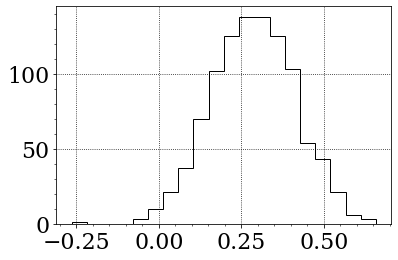

In [6]:
#plt.hist(res.loc['sigma'].values.ravel(),histtype='step',bins=75)
#plt.hist(res[1].values.ravel(),histtype='step',bins=100)
plt.hist(res[2].loc['sigma'].values.ravel(),histtype='step',bins=20)
plt.show()

In [7]:
res[0].to_csv('pi0_diagnostics.csv')
res[1].to_csv('pi0_sigma.csv')
res[2].to_csv('pi0_sigma_chi2.csv')
#res.to_csv('sigma_chi2.csv')

In [41]:
hp45=fit(nsamples=1000,nbins=1,start=0)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



fitted toyMC exp. no. 0


Warning in <TROOT::Append>: Replacing existing TH1: hp45_0 (Potential memory leak).


In [42]:
c=r.TCanvas("c","c")
c.Draw("")
hp45.Draw("ep")


f=r.TF1("f","[0]*(1-0.3*0.5*TMath::Cos(2*(45-x)*TMath::Pi()/180))")
hp45.Fit(f,"S")

 FCN=10.1617 FROM MIGRAD    STATUS=CONVERGED      12 CALLS          13 TOTAL
                     EDM=2.56182e-13    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.15820e+02   5.88657e+00   1.03590e-02  -1.21598e-07


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
